# MNIST meets RND

In this tutorial, we go over how to apply random network distillation to non-standard network architectures, specifically, the convoltutional neural networks required to classify the MNIST dataset.

In [6]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


import znrnd as rnd

import tensorflow_datasets as tfds

import numpy as np
from flax import linen as nn
import optax

from jax.lib import xla_bridge

print(f"Using: {xla_bridge.get_backend().platform}")

Using: cpu


### Making a data generator

The first thing we need to do is create a data generator for the problem.

In [7]:
data_generator = rnd.data.MNISTGenerator()

### Define the agent

In [8]:
class CustomModule(nn.Module):
    """
    Simple CNN module.
    """
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(features=256)(x)
        return x

In [9]:
class ProductionModule(nn.Module):
    """
    Simple CNN module.
    """

    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=128, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(3, 3), strides=(2, 2))
        x = nn.Conv(features=128, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(3, 3), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(features=300)(x)
        x = nn.relu(x)
        x = nn.Dense(10)(x)

        return x

In [19]:
production_model = rnd.models.FlaxModel(
            flax_module=ProductionModule(),
            optimizer=optax.adam(learning_rate=0.01),
            input_shape=(1, 28, 28, 1),
        )

production_training = rnd.training_strategies.SimpleTraining(
    model=production_model, 
    loss_fn=rnd.loss_functions.CrossEntropyLoss(),
    accuracy_fn=rnd.accuracy_functions.LabelAccuracy()
)

In [12]:
_ = production_training.train_model(
    train_ds={"inputs": data_generator.train_ds["inputs"], "targets": data_generator.train_ds["targets"]},
    test_ds={"inputs": data_generator.test_ds["inputs"], "targets": data_generator.test_ds["targets"]},
    batch_size=32,
)

Epoch: 50: 100%|███████████████████████████████████| 50/50 [01:01<00:00,  1.23s/batch, accuracy=0.1]


In [20]:
target = rnd.models.FlaxModel(
        flax_module=CustomModule(),
        optimizer=optax.adam(learning_rate=0.001),
        input_shape=(1, 28, 28, 1),
    )

predictor = rnd.models.FlaxModel(
        flax_module=CustomModule(),
        optimizer=optax.adam(learning_rate=0.001),
        input_shape=(1, 28, 28, 1),
    )

predictor_training = rnd.training_strategies.SimpleTraining(
    model=predictor, 
    loss_fn=rnd.loss_functions.MeanPowerLoss(order=2),
    recursive_use=True, 
    recursive_threshold=0.001
)

In [21]:
agent = rnd.agents.RND(
    training_strategy=predictor_training,
    point_selector=rnd.point_selection.GreedySelection(threshold=0.01),
    distance_metric=rnd.distance_metrics.OrderNDifference(order=2),
    data_generator=data_generator,
    target_network=target,
    predictor_network=predictor,
    tolerance=8,
    )

In [22]:
ds = agent.build_dataset(target_size=5, visualize=True)

/tikhome/knikolaou/miniconda3/envs/jax/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.

/tikhome/knikolaou/miniconda3/envs/jax/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.

Epoch: 50: 100%|███████████████████████████████| 50/50 [00:00<00:00, 74.40batch/s, test_loss=2.7e-5]
/tikhome/knikolaou/miniconda3/envs/jax/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.

Epoch: 50: 100%|██████████████████████████████| 50/50 [00:00<00:00, 51.22batch/s, test_loss=6.72e-8]
/tikhome/knikolaou/minicond

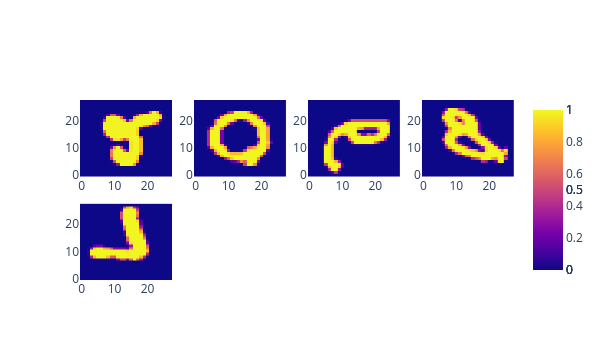

In [23]:
data_generator.plot_image(data_list=np.array(agent.target_set))